# Graph Embedding

Graph embedding attemps to transform a given graph G into a vectorial representation. This operation consists of mapping two domains: the Graph domain and the Embedding domain while preserving pertinent information. Embeddings may concern nodes (Node embedding), edges (Edge embedding), or both (Graph embedding).

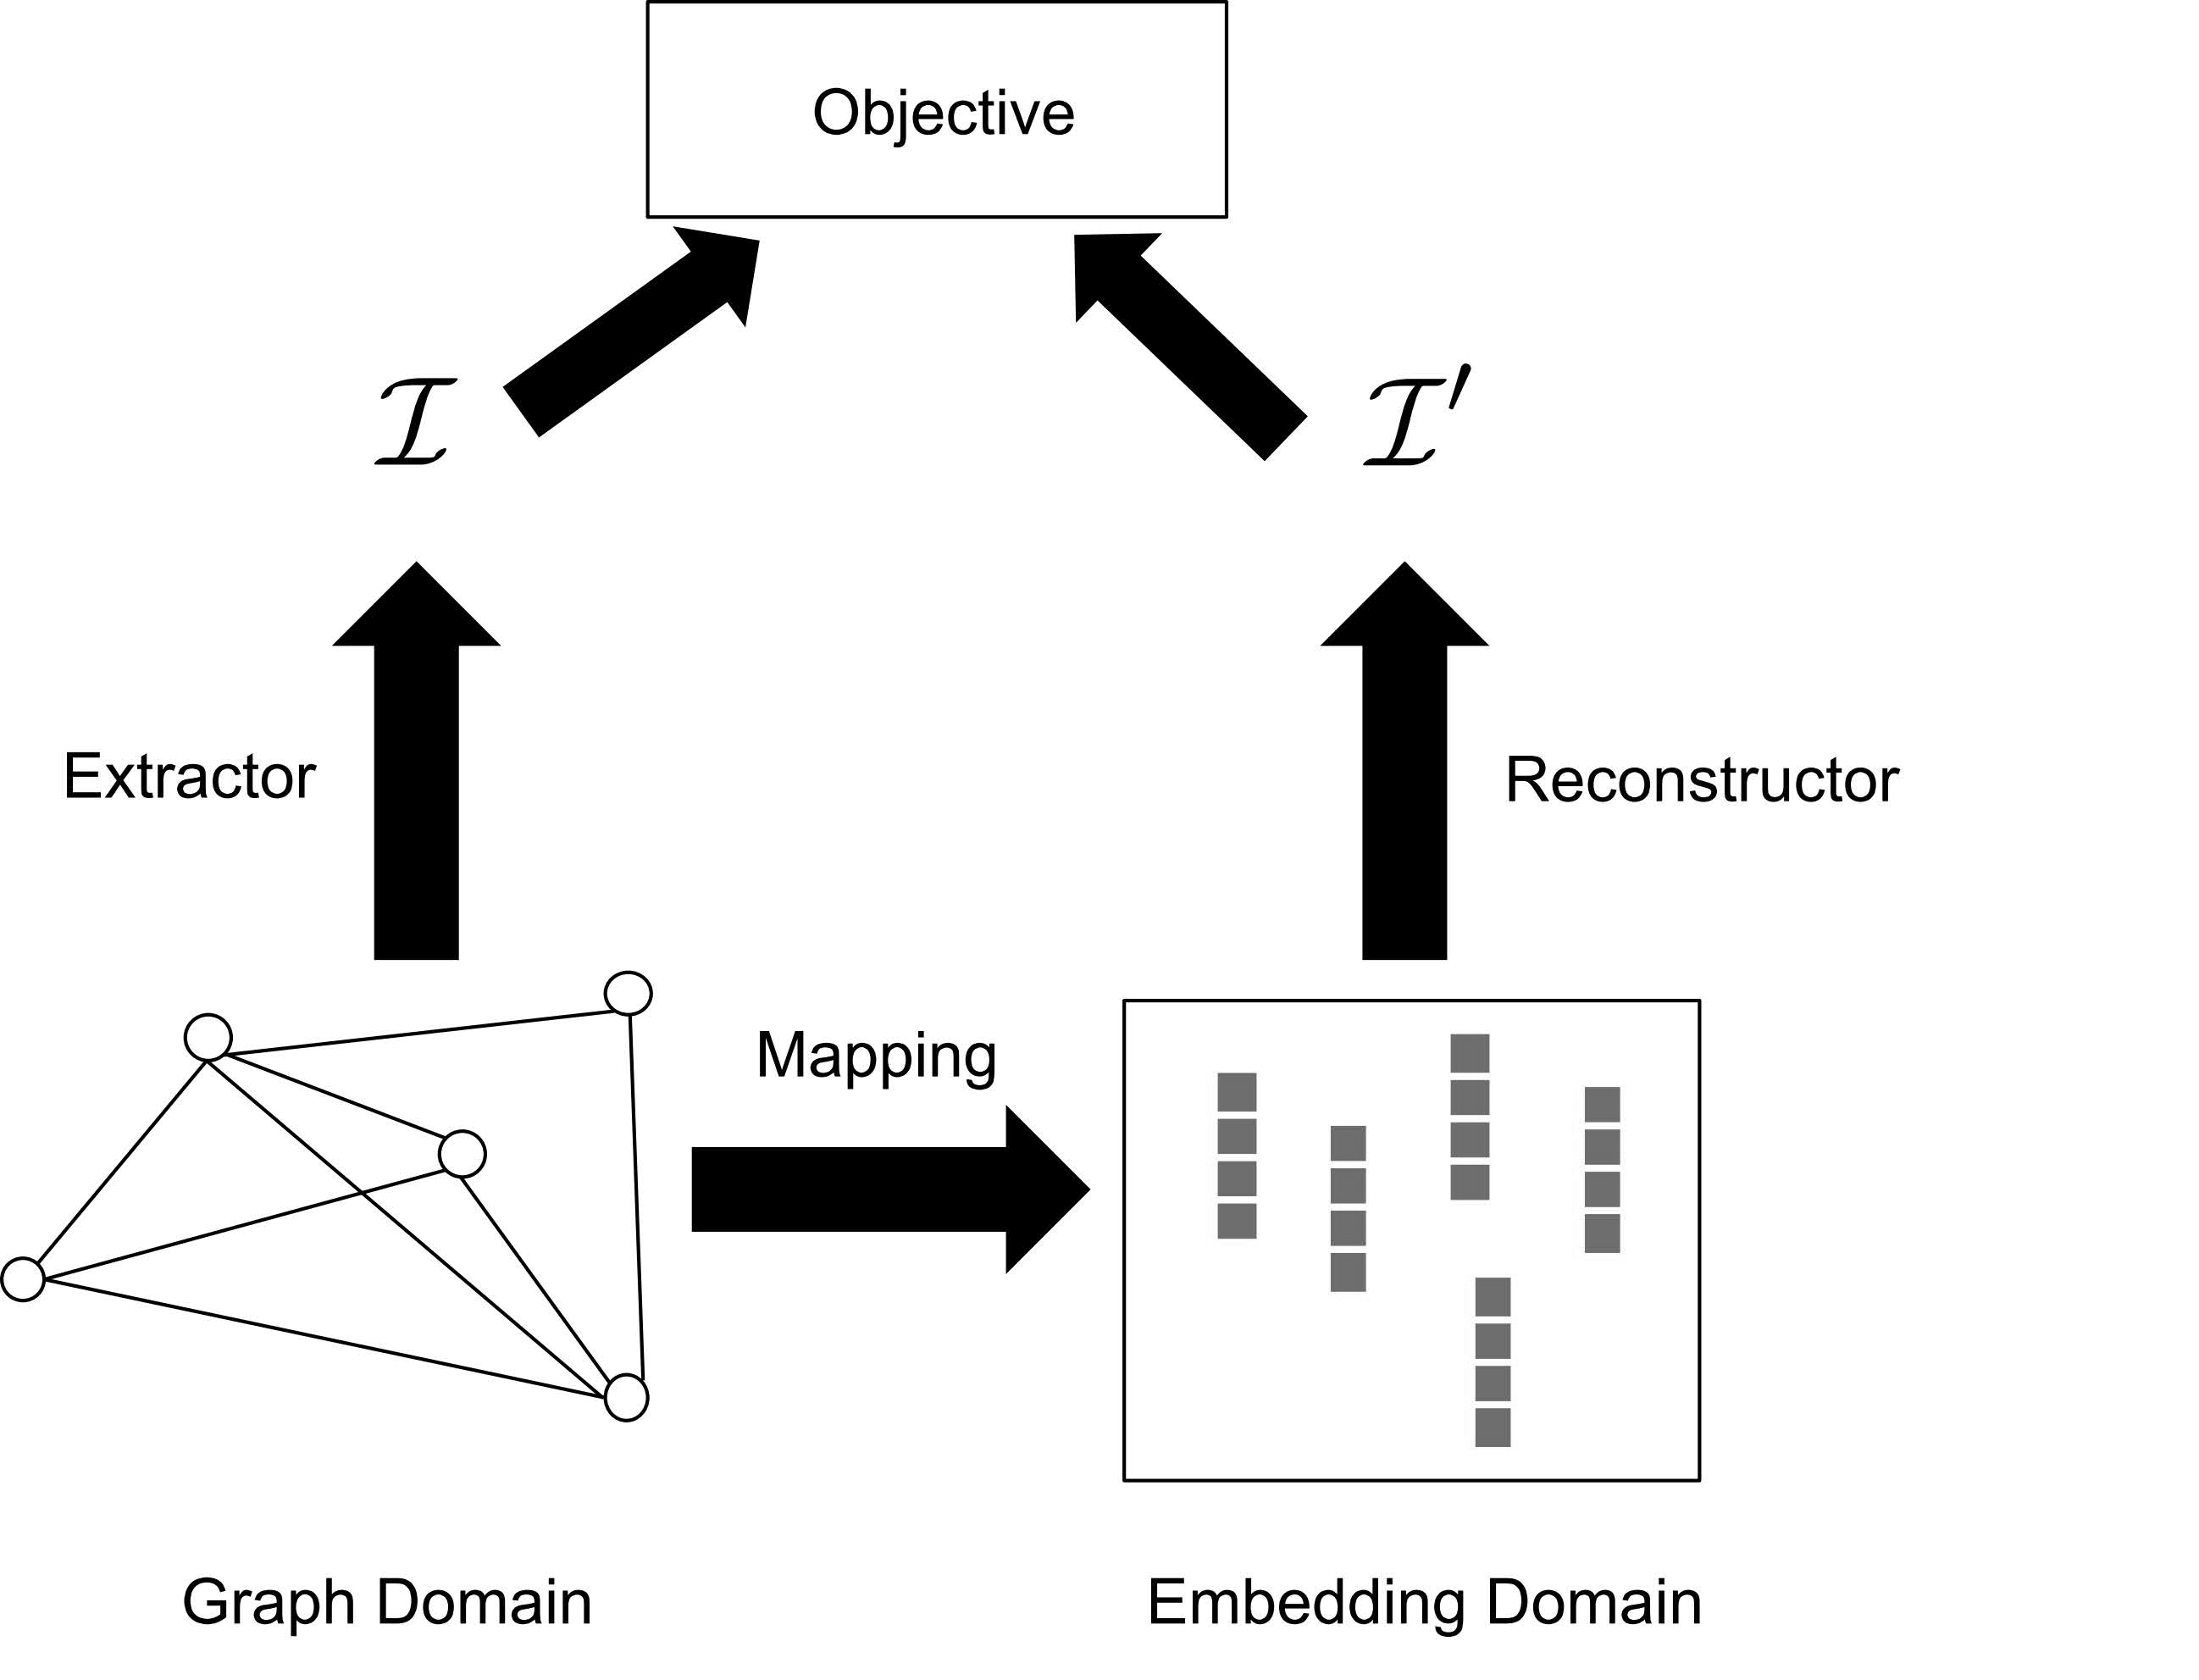

The embeding framework contains the following parts:
- Mapping function: Pass from the graph domain into the embedding domain, by taking the graph structure as input and return a representation of the graph a.k.a embedding.
- Extractor (resp. Reconstructor): Extract relevant information from the graph (resp. embeddings).
- Objective: Extracted Information should match so that it is possible to reconstruct the original graph using the embeddings.


Graph embedding methods differ depending on the information maintained such as:
- Node Co-occurrence: From a randomly generated sequence of nodes.
- Structural Role : Be able to extract similarity between distant nodes with similar structure (such as degree, ...). 
- Node Status: Maintain global score ranking (centrality for instance).
- Community Structure: Maintain the connectivity (Adjacency), and the neighborhood similarity (Cosin similarity)

## 1- Preserving Node Co-occurence

### - Deep Walk (Perozzi et al., 2014)

#### Description
Apply several random walks on the graph to extract sequences of nodes then apply word2vec (Skip-gram) to obtain embeddings.

- A random walk on a graph is a Marcov Chain where the states are the nodes and the matrix of transition probabilities P is defined as follows:

$$P^{(ij)}
= \begin{cases}
1/degree(i) & \text{ if } e^{(ij)} \epsilon E\\ 
0  & \text{ otherwise } 
\end{cases}
$$

- The SkipGram model is illustrated as follows:

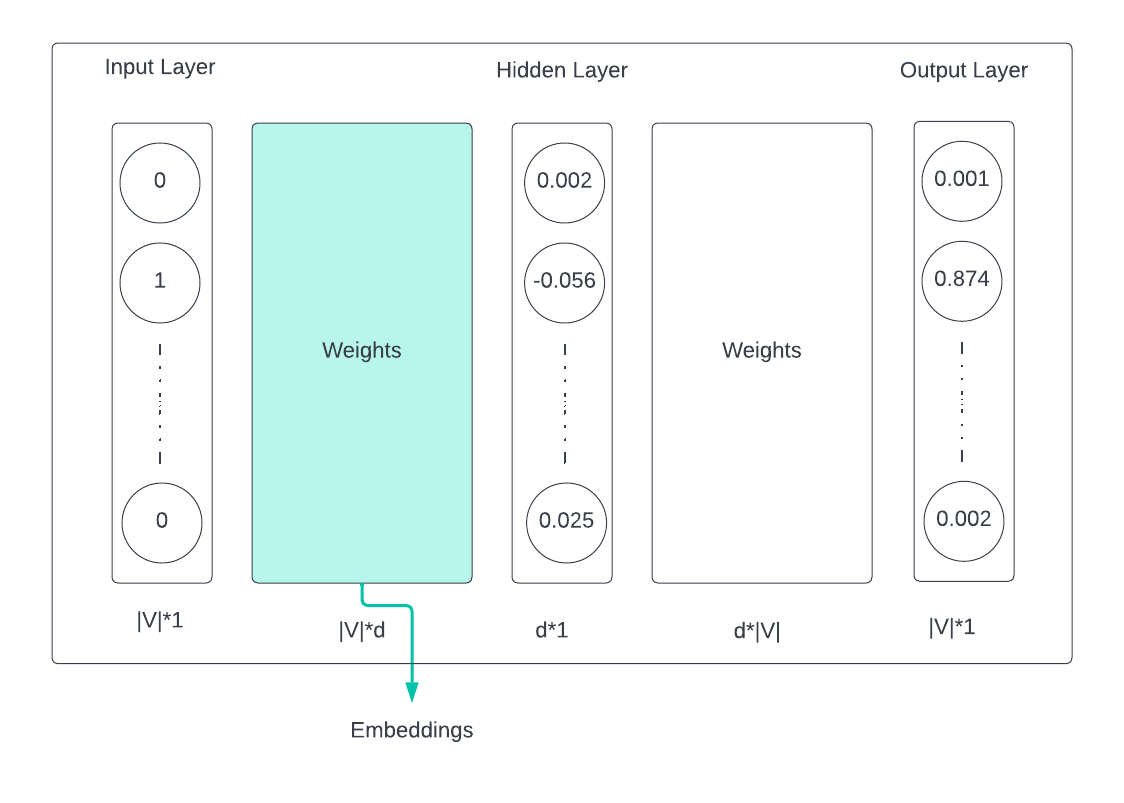
Where:

 The Input Layer is a OneHot vector that represents the word (i.e. Node) whithin the vocabulary (V: Set of Nodes).

 The Hidden layer contains d neurones (i.e. d features to learn) whithout activation, which delimits the embedding size.

 The Output layer has |V| neurones with Softmax as activation which determines the probabilities $P(v_{con}/v_{cen})$.
 
 
#### DW use cases
Anomaly Detection, Clustering, Link Prediction, etc. 


#### Graph domain
The original graph G=(V, E) with N nodes and M edges.

#### Embedding domain 
N vector representation of each node where the vector contains the probability of co-occurence.

#### Mapping function 
Nodes are mapped to their respective embedding by projecting the OneHot vector into the matrix of embeddings using the function $\text Φ: v ∈ V → R^{|V|×d}$, where d is the size of the embedding (d = Number of neurones in the hidden layer within SkipGram).


#### Extractor I
I contains pairs of nodes ($\text v^{(con)}, v^{(cen)}$) where $\text v^{(con)}$ is the context node associated to the center node $\text v^{(cen)}$. These pairs are used as training samples for the SkipGram model.

#### Reconstructor I'
$$I' = Rec(I) =\prod_{(v_{cen}, v_{con})∈I} P(v_{con}/v_{cen})$$

#### Objective function to minimize

$$Loss = -\sum_{(v_{con}, v_{cen})∈I} log(P(v_{con}/v_{cen}))$$


In [48]:
## Paper link: https://arxiv.org/pdf/1403.6652.pdf
## DeepWalk -- Code link: https://towardsdatascience.com/exploring-graph-embeddings-deepwalk-and-node2vec-ee12c4c0d26d
## Word2Vec -- Fct link: https://radimrehurek.com/gensim/models/word2vec.html?highlight=models%20word2vec#module-gensim.models.word2vec
########################################################################################################################################
## Primary modifications
# - Correct function 'random_walk': The random walk generates an additional node
# - Add parameter: 'hs', 'negative' in function 'compute_embeddings'
# - Add function extractor_I
########################################################################################################################################

import networkx as nx
import random
import numpy as np
from typing import List
from tqdm import tqdm
from gensim.models.word2vec import Word2Vec


class DeepWalk:
    def __init__(self, window_size: int, embedding_size: int, walk_length: int, walks_per_node: int):
        """
        :param window_size: window size for the Word2Vec model
        :param embedding_size: size of the final embedding
        :param walk_length: length of the walk
        :param walks_per_node: number of walks per node
        """
        self.window_size = window_size
        self.embedding_size = embedding_size
        self.walk_length = walk_length
        self.walk_per_node = walks_per_node

    def random_walk(self, g: nx.Graph, start: str, use_probabilities: bool = False) -> List[str]:
        """
        Generate a random walk starting on start
        :param g: Graph
        :param start: starting node for the random walk
        :param use_probabilities: if True take into account the weights assigned to each edge to select the next candidate
        :return:
        """
        walk = [start]
        for i in range(self.walk_length-1):
            neighbours = g.neighbors(walk[i])
            neighs = list(neighbours)
            if use_probabilities:
                probabilities = [g.get_edge_data(walk[i], neig)["weight"] for neig in neighs]
                sum_probabilities = sum(probabilities)
                probabilities = list(map(lambda t: t / sum_probabilities, probabilities))
                p = np.random.choice(neighs, p=probabilities)
            else:
                p = random.choice(neighs)
            walk.append(p)
        return walk

    def get_walks(self, g: nx.Graph, use_probabilities: bool = False) -> List[List[str]]:
        """
        Generate all the random walks
        :param g: Graph
        :param use_probabilities:
        :return:
        """
        random_walks = []
        for _ in range(self.walk_per_node):
            random_nodes = list(g.nodes)
            random.shuffle(random_nodes)
            for node in tqdm(random_nodes):
                random_walks.append(self.random_walk(g=g, start=node, use_probabilities=use_probabilities))
        return random_walks

    def compute_embeddings(self, walks: List[List[str]], hs = 1, negative=0):
        """
        Compute the node embeddings for the generated walks
        :param walks: List of walks
        :param hs: hs=1(default) for Hierarchical Softmax, hs=0 for Negative Sampling
        :param negative: If > 0, negative sampling will be used. If set to 0, no negative sampling is used.
        :return:
        """
        model = Word2Vec(sentences=walks, window=self.window_size, vector_size=self.embedding_size, sg=1, hs=hs, negative=negative)
        return model.wv
    
    def extractor_I(self, walks):
        """
        Extract training samples, aka pairs (Vcen, V(con)) from the random walks
        :param walks: List of walks
        :return:
        """
        I = []
        for walk in walks:
            for i in range(self.walk_length):
                for j in range(1, self.window_size+1):
                    if (i-j>=0): I.append((walk[i], walk[i-j]))
                    if (i+j<self.walk_length): I.append((walk[i], walk[i+j]))

        return I

Graph info:
Number of nodes N = 10
Number of edges M = 12


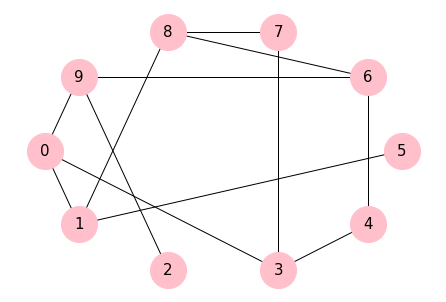

Adjacency matrix A:


,0,1,2,3,4,5,6,7,8,9
0,0,1,0,1,0,0,0,0,0,1
1,1,0,0,0,0,1,0,0,1,0
2,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,1,0,0,1,0,0
4,0,0,0,1,0,0,1,0,0,0
5,0,1,0,0,0,0,0,0,0,0
6,0,0,0,0,1,0,0,0,1,1
7,0,0,0,1,0,0,0,0,1,0
8,0,1,0,0,0,0,1,1,0,0
9,1,0,1,0,0,0,1,0,0,0



Matrix of Transition probabilities P:


,0,1,2,3,4,5,6,7,8,9
0,0.00,0.33,0.00,0.33,0.00,0.00,0.00,0.00,0.00,0.33
1,0.33,0.00,0.00,0.00,0.00,0.33,0.00,0.00,0.33,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
3,0.33,0.00,0.00,0.00,0.33,0.00,0.00,0.33,0.00,0.00
4,0.00,0.00,0.00,0.50,0.00,0.00,0.50,0.00,0.00,0.00
5,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.33,0.00,0.00,0.00,0.33,0.33
7,0.00,0.00,0.00,0.50,0.00,0.00,0.00,0.00,0.50,0.00
8,0.00,0.33,0.00,0.00,0.00,0.00,0.33,0.33,0.00,0.00
9,0.33,0.00,0.33,0.00,0.00,0.00,0.33,0.00,0.00,0.00


In [49]:
import warnings
warnings.simplefilter("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# Generate a random graph with 10 nodes and 12 edges
G = nx.gnm_random_graph(n=10 , m=12 , seed=2451)
print("Graph info:")
print("Number of nodes N =", G.number_of_nodes())
print("Number of edges M =", G.number_of_edges())

plt.figure()
pos = nx.shell_layout(G)
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=1300, node_color='pink', font_size=15,
    labels={node: node for node in G.nodes()}
)
plt.show()


A = pd.DataFrame(nx.to_numpy_matrix(G).astype(int))
A.index = A.columns = range(G.number_of_nodes())
print('Adjacency matrix A:')
display(A)

P = pd.DataFrame(np.around(A.T/A.sum(axis=0).T, decimals=2)).T
print('\nMatrix of Transition probabilities P:')
display(P)

In [50]:
DW = DeepWalk(window_size=1, embedding_size=3, walk_length=4, walks_per_node=3)
walks = DW.get_walks(G)
embeddings = DW.compute_embeddings(walks)
I = DW.extractor_I(walks)

100%|██████████| 10/10 [00:00<?, ?it/s]


The first 3 random walks:  [[0, 9, 0, 9], [3, 0, 9, 6], [2, 9, 2, 9]]
Extracted information from the 1st walk I = [(0, 9), (9, 0), (9, 0), (0, 9), (0, 9), (9, 0)]

Embedding of the Node 6: [-0.12542596  0.24597876 -0.05110861]
Embedding of the Node 8: [-0.15111166  0.21836752 -0.16199979]
Cosine Similarity between Nodes 6 and 8: 0.92671317

Embeddings plotted in 2D


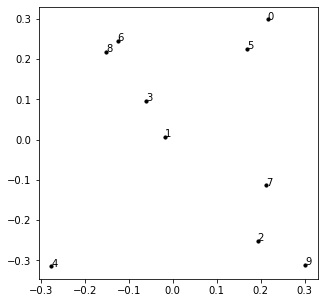

In [52]:
print("The first 3 random walks: ", walks[:3])
print("Extracted information from the 1st walk I =", I[:6])

print("\nEmbedding of the Node 6:", embeddings[6])
print("Embedding of the Node 8:", embeddings[8])
print("Cosine Similarity between Nodes 6 and 8:", embeddings.similarity(6, 8))

z = np.array([embeddings[i] for i in range(G.number_of_nodes())])
print("\nEmbeddings plotted in 2D")
plt.figure(figsize=(5, 5))
plt.scatter(z[:, 0], z[:, 1], color='black', s=10)
for i, txt in enumerate(range(G.number_of_nodes())):
    plt.annotate(txt, (z[i, 0], z[i, 1]))
plt.show()

### - Node2Vec (Grover and Leskovec, 2016)

In [2]:
from torch_geometric.nn import Node2Vec
import os.path as osp
import torch
from torch_geometric.datasets import Planetoid
from tqdm.notebook import tqdm

dataset = 'Cora'
path = osp.join('.', 'data', dataset)
dataset = Planetoid(path, dataset)  # dowload or load the Cora dataset
data = dataset[0]
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # check if cuda is available to send the model and tensors to the GPU
model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
                 context_size=10, walks_per_node=10,
                 num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=4)  # data loader to speed the train 
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)  # initzialize the optimizer 


def train():
    model.train()  # put model in train model
    total_loss = 0
    for pos_rw, neg_rw in tqdm(loader):
        optimizer.zero_grad()  # set the gradients to 0
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))  # compute the loss for the batch
        loss.backward()
        optimizer.step()  # optimize the parameters
        total_loss += loss.item()
    return total_loss / len(loader)


for epoch in range(1, 10):
    loss = train()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

all_vectors = ""
for tensor in model(torch.arange(data.num_nodes, device=device)):
    s = "\t".join([str(value) for value in tensor.detach().cpu().numpy()])
    all_vectors += s + "\n"
# save the vectors
with open("vectors.txt", "w") as f:
    f.write(all_vectors)
# save the labels
with open("labels.txt", "w") as f:
    f.write("\n".join([str(label) for label in data.y.numpy()]))

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 01, Loss: 8.1424


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 02, Loss: 6.0813


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 03, Loss: 4.9768


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 04, Loss: 4.1532


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 05, Loss: 3.5009


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 06, Loss: 2.9782


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 07, Loss: 2.5632


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 08, Loss: 2.2315


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 09, Loss: 1.9644
